In [1]:
# MLM 방식을 이용한 Further pre-traning 방식 구현 예제
# 참고 소스 : https://towardsdatascience.com/masked-language-modelling-with-bert-7d49793e5d2c 참조 바람
import torch
import os

from tqdm.notebook import tqdm
from transformers import BertTokenizer, BertConfig, BertForMaskedLM, BertTokenizerFast
from transformers import AdamW, get_linear_schedule_with_warmup
from os import sys
sys.path.append('..')
from myutils import GPU_info, seed_everything, mlogging, AccuracyForMLM, SaveBERTModel

logfilepath:../../log/bwdataset_2022-04-22.log
logfilepath:../../log/qnadataset_2022-04-22.log


In [2]:
# 훈련시킬 말뭉치(사전 만들때 동일한 말뭉치 이용)
#input_corpus = "../korpora/kowiki_20190620/wiki_20190620_mecab_false_0311.txt"
#input_corpus = "../../korpora/kowiki_20190620/wiki_20190620_small.txt"
input_corpus = "../../korpora/mycorpus/bong_corpus_mecab.txt"

# eval 말뭉치 
eval_corpus = "../../korpora/kowiki_20190620/wiki_eval_test.txt"

# 기존 사전훈련된 모델
model_path = "../../model/bert/bert-multilingual-cased/"

# 기존 사전 + 추가된 사전 파일
#vocab_path="../../tokenizer/wiki_20190620_nouns_0324"
vocab_path="../../tokenizer/my_vocab"

# 출력
OUTPATH = '../../model/bert/bmc-fpt-bong_corpus_mecab-0424/'

batch_size = 32
token_max_len = 128

device = GPU_info()
print(device)

#seed 설정
seed_everything(111)

#logging 설정
logger =  mlogging(loggername="bertfpt3", logfilename="bertfpt3")

True
device: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA A30
cuda:0
logfilepath:bertfpt3_2022-04-22.log


In [3]:
# tokeinzier 생성
# tokenizer 생성
# => BertTokenizer, BertTokenizerFast 둘중 사용하면됨

#tokenizer = BertTokenizer(vocab_file=vocab_path, max_len=token_max_len, do_lower_case=False)
tokenizer = BertTokenizer.from_pretrained(vocab_path, max_len=token_max_len, do_lower_case=False)
# tokenizer = BertTokenizerFast(vocab_file=vocab_file, max_len=token_max_len, do_lower_case=False)


# speical 토큰 계수 + vocab 계수 - 이미 vocab에 포함된 speical 토큰 계수(5)
vocab_size = len(tokenizer.all_special_tokens) + tokenizer.vocab_size - 5 + 1
#vocab_size = len(tokenizer.all_special_tokens) + tokenizer.vocab_size - 5
print('special_token_size: {}, tokenizer.vocab_size: {}'.format(len(tokenizer.all_special_tokens), tokenizer.vocab_size))
print('vocab_size: {}'.format(vocab_size))
print('tokenizer_len: {}'.format(len(tokenizer)))

# 모델 로딩 further pre-training 
#config = BertConfig.from_pretrained(model_path)
#model = BertForMaskedLM.from_pretrained(model_path, from_tf=bool(".ckpt" in model_path), config=config) 
#model = BertForMaskedLM.from_pretrained('bert-base-multilingual-cased', cache_dir='test')    
model = BertForMaskedLM.from_pretrained(model_path)

#################################################################################
# 모델 embedding 사이즈를 tokenizer 크기 만큼 재 설정함.
# 재설정하지 않으면, 다음과 같은 에러 발생함
# CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)` CUDA 에러가 발생함
#  indexSelectLargeIndex: block: [306,0,0], thread: [0,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
#
#     해당 오류는 기존 Embedding(8002, 768, padding_idx=1) 처럼 입력 vocab 사이즈가 8002인데,
#     0~8001 사이를 초과하는 word idx 값이 들어가면 에러 발생함.
#################################################################################
#167550
model.resize_token_embeddings(len(tokenizer))

model.to(device)

special_token_size: 5, tokenizer.vocab_size: 149793
vocab_size: 149794
tokenizer_len: 149793


Some weights of the model checkpoint at ../../model/bert/bert-multilingual-cased/ were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(149793, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          

In [4]:
from torch.utils.data import DataLoader, RandomSampler
import sys
sys.path.append('..')
from myutils import MLMDataset

# 각 스페셜 tokenid를 구함
CLStokenid = tokenizer.convert_tokens_to_ids('[CLS]')
SEPtokenid = tokenizer.convert_tokens_to_ids('[SEP]')
UNKtokenid = tokenizer.convert_tokens_to_ids('[UNK]')
PADtokenid = tokenizer.convert_tokens_to_ids('[PAD]')
MASKtokenid = tokenizer.convert_tokens_to_ids('[MASK]')
print('CLSid:{}, SEPid:{}, UNKid:{}, PADid:{}, MASKid:{}'.format(CLStokenid, SEPtokenid, UNKtokenid, PADtokenid, MASKtokenid))


train_dataset = MLMDataset(corpus_path = input_corpus,
                           tokenizer = tokenizer, 
                           CLStokeinid = CLStokenid ,   # [CLS] 토큰 id
                           SEPtokenid = SEPtokenid ,    # [SEP] 토큰 id
                           UNKtokenid = UNKtokenid ,    # [UNK] 토큰 id
                           PADtokenid = PADtokenid,    # [PAD] 토큰 id
                           Masktokenid = MASKtokenid,   # [MASK] 토큰 id
                           max_sequence_len=token_max_len,  # max_sequence_len)
                           mlm_probability=0.15,
                           overwrite_cache=True
                          )


# 학습 dataloader 생성
# => tenosor로 만듬
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          #shuffle=True, # dataset을 섞음
                          sampler=RandomSampler(train_dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          num_workers=3
                         )

#===============================================================================
# eval dataloader 생성
eval_dataset = MLMDataset(corpus_path = eval_corpus,
                          tokenizer = tokenizer, 
                          CLStokeinid = CLStokenid ,   # [CLS] 토큰 id
                          SEPtokenid = SEPtokenid ,    # [SEP] 토큰 id
                          UNKtokenid = UNKtokenid ,    # [UNK] 토큰 id
                          PADtokenid = PADtokenid,    # [PAD] 토큰 id
                          Masktokenid = MASKtokenid,   # [MASK] 토큰 id
                          max_sequence_len=token_max_len,  # max_sequence_len)
                          mlm_probability=0.15,
                          overwrite_cache=True
                          )


# eval dataloader 생성
# => tenosor로 만듬
eval_loader = DataLoader(eval_dataset, 
                         batch_size=batch_size, 
                         #shuffle=True, # dataset을 섞음
                         sampler=RandomSampler(eval_dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                         num_workers=3
                         )
#===============================================================================

print(train_dataset[0])

CLSid:101, SEPid:102, UNKid:100, PADid:0, MASKid:103
*corpus:../../korpora/mycorpus/bong_corpus_mecab.txt
*max_sequence_len:128
*mlm_probability:0.15
*CLStokenid:101, SEPtokenid:102, UNKtokenid:100, PADtokeinid:0, Masktokeid:103
*total_line: 3339430


  0%|          | 0/3339430 [00:00<?, ?it/s]

  0%|          | 0/3339430 [00:00<?, ?it/s]

2022-04-23 06:21:59,963 - bwpdataset - INFO - ==>[Start] cached file create: ../../korpora/mycorpus/cached_lm_BertTokenizer_128_bong_corpus_mecab.txt
2022-04-23 06:22:54,698 - bwpdataset - INFO - <==[End] Saving features into cached file ../../korpora/mycorpus/cached_lm_BertTokenizer_128_bong_corpus_mecab.txt [took 54.734 s]


*corpus:../../korpora/kowiki_20190620/wiki_eval_test.txt
*max_sequence_len:128
*mlm_probability:0.15
*CLStokenid:101, SEPtokenid:102, UNKtokenid:100, PADtokeinid:0, Masktokeid:103
*total_line: 114


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

2022-04-23 06:22:54,786 - bwpdataset - INFO - ==>[Start] cached file create: ../../korpora/kowiki_20190620/cached_lm_BertTokenizer_128_wiki_eval_test.txt
2022-04-23 06:22:54,788 - bwpdataset - INFO - <==[End] Saving features into cached file ../../korpora/kowiki_20190620/cached_lm_BertTokenizer_128_wiki_eval_test.txt [took 0.001 s]


{'input_ids': tensor([   101,  24895,  37010,    103,   9632, 123360,   9637, 144398, 136581,
        110148,    103, 119796,   9955,   9460,   9647,   9043, 122873,   9245,
          9536,   9645,  48345,    102,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,   

In [5]:
##################################################
epochs = 4            # epochs
learning_rate = 3e-5  # 학습률
##################################################

# optimizer 적용
optimizer = AdamW(model.parameters(), 
                 lr=learning_rate, 
                 eps=1e-8) # 0으로 나누는 것을 방지하기 위한 epsilon 값(10^-6 ~ 10^-8 사이 이값 입력합)

# 총 훈련과정에서 반복할 스탭
total_steps = len(train_loader)*epochs
warmup_steps = total_steps * 0.1 #10% of train data for warm-up

# 손실률 보여줄 step 수
p_itr = int(len(train_loader)*0.1)  
    
# step마다 모델 저장
save_steps = int(total_steps * 0.2)
    
# 스캐줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps, 
                                            num_training_steps=total_steps)

itr = 1
total_loss = 0
total_len = 0
total_correct = 0
total_test_correct = 0
total_test_len = 0
    
list_train_loss = []
list_train_acc = []
list_validation_acc = []

model.zero_grad()# 그래디언트 초기화
for epoch in tqdm(range(epochs)):

    model.train() # 훈련모드로 변환
    for data in tqdm(train_loader):
        #optimizer.zero_grad()
        model.zero_grad()# 그래디언트 초기화
        
        # 입력 값 설정
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)       
        labels = data['labels'].to(device)
        #print('Labels:{}'.format(labels))
        
            
        # 모델 실행
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels)
        
       
        # 출력값 loss,logits를 outputs에서 얻어옴
        loss = outputs.loss
        logits = outputs.logits
        #print('Loss:{}, logits:{}'.format(loss, logits))
       
        # optimizer 과 scheduler 업데이트 시킴
        loss.backward()   # backward 구함
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # 그래디언트 클리핑 (gradient vanishing이나 gradient exploding 방지하기 위한 기법)
        optimizer.step()  # 가중치 파라미터 업데이트(optimizer 이동)
        scheduler.step()  # 학습률 감소
        
        # ***further pretrain 에는 손실률 계산을 넣지 않음
        # 정확도 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
        
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            
            # 손실률 계산
            total_loss += loss.item()
            
            #===========================================
            # 정확도(Accurarcy) 계산
            correct = AccuracyForMLM(logits, labels, attention_mask)
            total_correct += correct.sum().item() 
            total_len += attention_mask.sum().item() # 단어 총 수는 attension_mask가 1(True) 인 것들의 합
            #=========================================
                
            # 주기마다 test(validataion) 데이터로 평가하여 손실류 계산함.
            if itr % p_itr == 0:
                
                train_loss = total_loss/p_itr
                train_acc = total_correct/total_len
                       
                ####################################################################
                # 주기마다 eval(validataion) 데이터로 평가하여 손실류 계산함.
                # 평가 시작
                model.eval()

                #for data in tqdm(eval_loader):
                for data in eval_loader:
                    # 입력 값 설정
                    input_ids = data['input_ids'].to(device)
                    attention_mask = data['attention_mask'].to(device)
                    token_type_ids = data['token_type_ids'].to(device)       
                    labels = data['labels'].to(device)

                    with torch.no_grad():
                        # 모델 실행
                        outputs = model(input_ids=input_ids, 
                                       attention_mask=attention_mask,
                                       token_type_ids=token_type_ids,
                                       labels=labels)

                        # 출력값 loss,logits를 outputs에서 얻어옴
                        #loss = outputs.loss
                        logits = outputs.logits

                        #===========================================
                        # 정확도(Accurarcy) 계산
                        correct = AccuracyForMLM(logits, labels, attention_mask)
                        total_test_correct += correct.sum().item() 
                        total_test_len += attention_mask.sum().item()  # 단어 총 수는 attension_mask가 1(True) 인 것들의 합
                        #=========================================

                val_acc = total_test_correct/total_test_len
                    
                logger.info('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Train Acc: {:.4f}, Val Acc:{}'.format(epoch+1, epochs, itr, train_loss, train_acc, val_acc))
                    
                list_train_loss.append(train_loss)
                list_train_acc.append(train_acc)
                list_validation_acc.append(val_acc)
                 
                # 변수들 초기화    
                total_loss = 0
                total_len = 0
                total_correct = 0
                total_test_correct = 0
                total_test_len = 0
                ####################################################################

            if itr % save_steps == 0:
                #전체모델 저장
                SaveBERTModel(model, tokenizer, OUTPATH, epochs, learning_rate, batch_size)

        itr+=1
   

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/104357 [00:00<?, ?it/s]

2022-04-23 07:08:59,234 - bertfpt3 - INFO - [Epoch 1/4] Iteration 10435 -> Train Loss: 0.6883, Train Acc: 0.8651, Val Acc:0.8629056718228693
2022-04-23 07:54:40,955 - bertfpt3 - INFO - [Epoch 1/4] Iteration 20870 -> Train Loss: 0.1359, Train Acc: 0.9180, Val Acc:0.8586593873218077
2022-04-23 08:40:09,419 - bertfpt3 - INFO - [Epoch 1/4] Iteration 31305 -> Train Loss: 0.1175, Train Acc: 0.9247, Val Acc:0.848650288140734
2022-04-23 09:25:30,669 - bertfpt3 - INFO - [Epoch 1/4] Iteration 41740 -> Train Loss: 0.1075, Train Acc: 0.9282, Val Acc:0.8498635122838945
2022-04-23 10:11:04,389 - bertfpt3 - INFO - [Epoch 1/4] Iteration 52175 -> Train Loss: 0.1000, Train Acc: 0.9309, Val Acc:0.845920533818623
2022-04-23 10:56:30,370 - bertfpt3 - INFO - [Epoch 1/4] Iteration 62610 -> Train Loss: 0.0949, Train Acc: 0.9332, Val Acc:0.8392478010312405
2022-04-23 11:41:49,345 - bertfpt3 - INFO - [Epoch 1/4] Iteration 73045 -> Train Loss: 0.0912, Train Acc: 0.9348, Val Acc:0.8428874734607219
2022-04-23 12:2

  0%|          | 0/104357 [00:00<?, ?it/s]

2022-04-23 14:44:35,625 - bertfpt3 - INFO - [Epoch 2/4] Iteration 114785 -> Train Loss: 0.0822, Train Acc: 0.9386, Val Acc:0.8334849863512284
2022-04-23 15:29:42,332 - bertfpt3 - INFO - [Epoch 2/4] Iteration 125220 -> Train Loss: 0.0754, Train Acc: 0.9427, Val Acc:0.8346982104943889
2022-04-23 16:15:00,993 - bertfpt3 - INFO - [Epoch 2/4] Iteration 135655 -> Train Loss: 0.0750, Train Acc: 0.9429, Val Acc:0.8280254777070064
2022-04-23 17:00:07,454 - bertfpt3 - INFO - [Epoch 2/4] Iteration 146090 -> Train Loss: 0.0746, Train Acc: 0.9431, Val Acc:0.8313618441006976
2022-04-23 17:45:36,635 - bertfpt3 - INFO - [Epoch 2/4] Iteration 156525 -> Train Loss: 0.0739, Train Acc: 0.9436, Val Acc:0.8180163785259327
2022-04-23 18:31:05,073 - bertfpt3 - INFO - [Epoch 2/4] Iteration 166960 -> Train Loss: 0.0735, Train Acc: 0.9438, Val Acc:0.8143767060964513
2022-04-23 18:31:09,621 - bwpdataset - INFO - ==> save_model : ../../model/bert/bmc-fpt-bong_corpus_mecab-0424/batch:32-ep:4-lr:0.000030000-4m23d-18

  0%|          | 0/104357 [00:00<?, ?it/s]

2022-04-23 22:18:20,734 - bertfpt3 - INFO - [Epoch 3/4] Iteration 219135 -> Train Loss: 0.0691, Train Acc: 0.9455, Val Acc:0.805277525022748
2022-04-23 23:04:00,116 - bertfpt3 - INFO - [Epoch 3/4] Iteration 229570 -> Train Loss: 0.0603, Train Acc: 0.9515, Val Acc:0.8028510767364271
2022-04-23 23:49:25,895 - bertfpt3 - INFO - [Epoch 3/4] Iteration 240005 -> Train Loss: 0.0603, Train Acc: 0.9516, Val Acc:0.7979981801637852
2022-04-24 00:34:59,166 - bertfpt3 - INFO - [Epoch 3/4] Iteration 250440 -> Train Loss: 0.0603, Train Acc: 0.9516, Val Acc:0.794661813770094
2022-04-24 00:35:05,336 - bwpdataset - INFO - ==> save_model : ../../model/bert/bmc-fpt-bong_corpus_mecab-0424/batch:32-ep:4-lr:0.000030000-4m24d-0:35
2022-04-24 01:20:18,077 - bertfpt3 - INFO - [Epoch 3/4] Iteration 260875 -> Train Loss: 0.0602, Train Acc: 0.9517, Val Acc:0.7928419775553533
2022-04-24 02:05:36,136 - bertfpt3 - INFO - [Epoch 3/4] Iteration 271310 -> Train Loss: 0.0600, Train Acc: 0.9518, Val Acc:0.7898089171974523

  0%|          | 0/104357 [00:00<?, ?it/s]

2022-04-24 05:53:14,167 - bertfpt3 - INFO - [Epoch 4/4] Iteration 323485 -> Train Loss: 0.0613, Train Acc: 0.9501, Val Acc:0.7907188353048226
2022-04-24 06:38:44,120 - bertfpt3 - INFO - [Epoch 4/4] Iteration 333920 -> Train Loss: 0.0489, Train Acc: 0.9595, Val Acc:0.786472550803761
2022-04-24 06:38:50,918 - bwpdataset - INFO - ==> save_model : ../../model/bert/bmc-fpt-bong_corpus_mecab-0424/batch:32-ep:4-lr:0.000030000-4m24d-6:38
2022-04-24 07:24:01,212 - bertfpt3 - INFO - [Epoch 4/4] Iteration 344355 -> Train Loss: 0.0486, Train Acc: 0.9597, Val Acc:0.7840461025174401
2022-04-24 08:09:09,194 - bertfpt3 - INFO - [Epoch 4/4] Iteration 354790 -> Train Loss: 0.0486, Train Acc: 0.9598, Val Acc:0.7855626326963907
2022-04-24 08:54:28,412 - bertfpt3 - INFO - [Epoch 4/4] Iteration 365225 -> Train Loss: 0.0485, Train Acc: 0.9599, Val Acc:0.7849560206248104
2022-04-24 09:39:39,377 - bertfpt3 - INFO - [Epoch 4/4] Iteration 375660 -> Train Loss: 0.0484, Train Acc: 0.9601, Val Acc:0.78374279648165


In [7]:
# 모델 저장
SaveBERTModel(model, tokenizer, OUTPATH, epochs, learning_rate, batch_size)

2022-04-25 08:27:49,379 - bwpdataset - INFO - ==> save_model : ../../model/bert/bmc-fpt-bong_corpus_mecab-0424/batch:32-ep:4-lr:0.000030000-4m25d-8:27


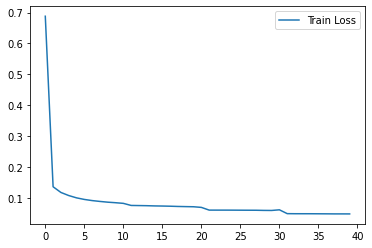

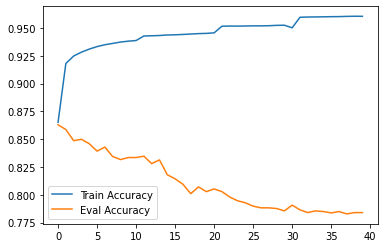

In [8]:
# 그래프로 loss 표기
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(list_train_loss, label='Train Loss')
#plt.plot(list_train_acc, label='Train Accuracy')
#plt.plot(list_validation_acc, label='Eval Accuracy')
plt.legend()
plt.show()

plt.plot(list_train_acc, label='Train Accuracy')
plt.plot(list_validation_acc, label='Eval Accuracy')
plt.legend()
plt.show()